# Harmonic Oscillator

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from hamilton_class import HamiltonSystem
from plot_class import Plotter
from nambu_class import NambuSystem

### Single initial condition using Hamilton dynamics


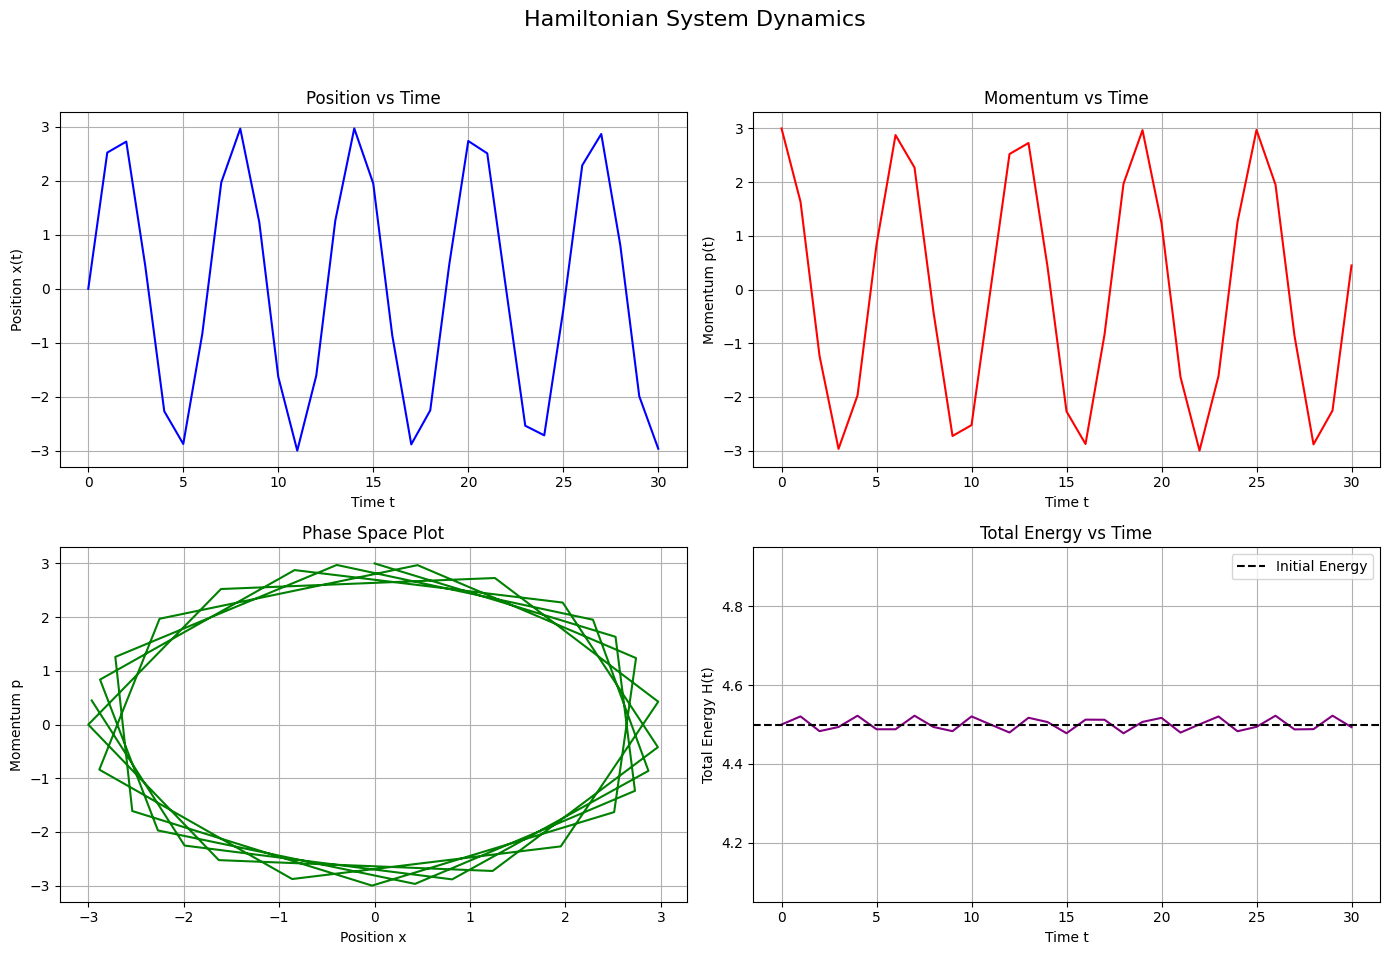

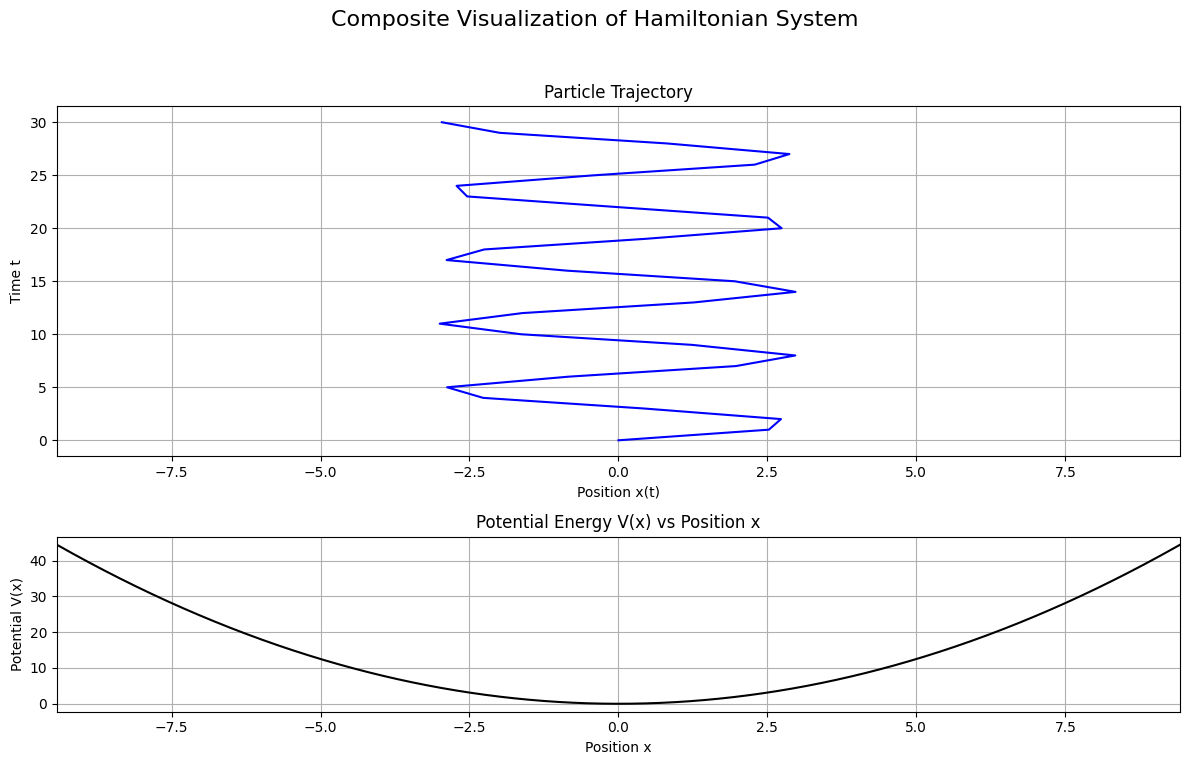

In [16]:
# Define the parameters
k = 1.0  # Spring constant
m = 1.0  # Mass
t_max = 30.0  # Maximum time
delta_t = 0.01  # Time step

def p_dot(x, p):
    return -k * x  # For a simple harmonic oscillator, dp/dt = -k x

def x_dot(x, p):
    return p / m  # For a simple harmonic oscillator, dx/dt = p / m

# Create Hamiltonian system
hamilton_system = HamiltonSystem(p_dot, x_dot, t_max, delta_t)

# Fixed initial condition
x0, p0 = 0.0, 3.0

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)

# Sample the data
t_sampled, x_sampled, p_sampled = hamilton_system.sample_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = 0.5 * (p_sampled**2) / m + k * (x_sampled**2) / 2
potential = lambda x: k * (x**2) / 2

# Plotting
plotter = Plotter()
plotter.static_plots(t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.composite_plot(x_sampled, t_sampled, potential)

### Single initial condition using Nambu dynamics

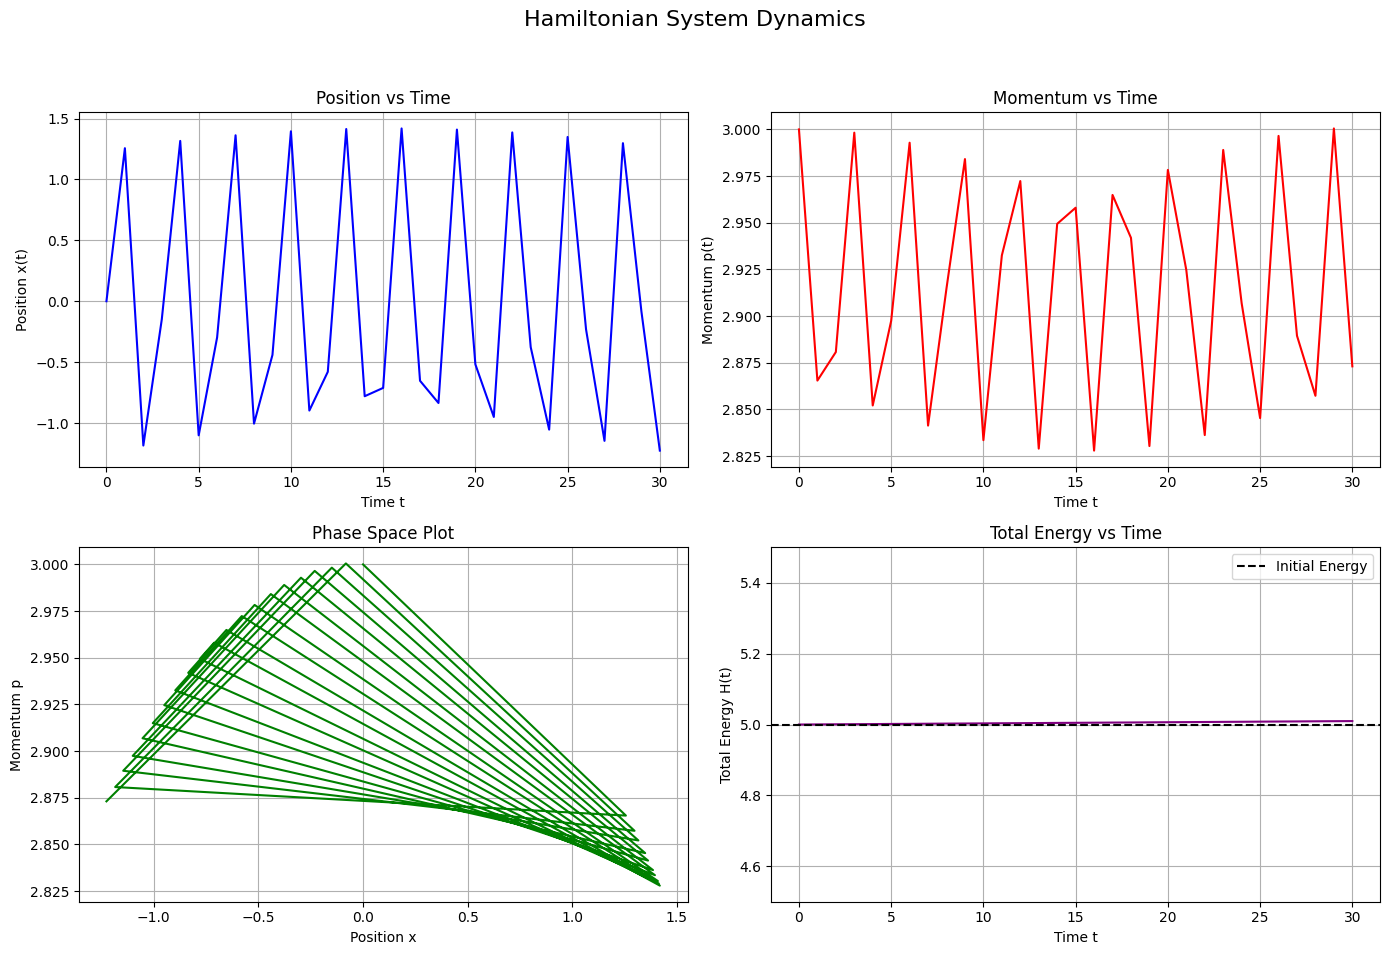

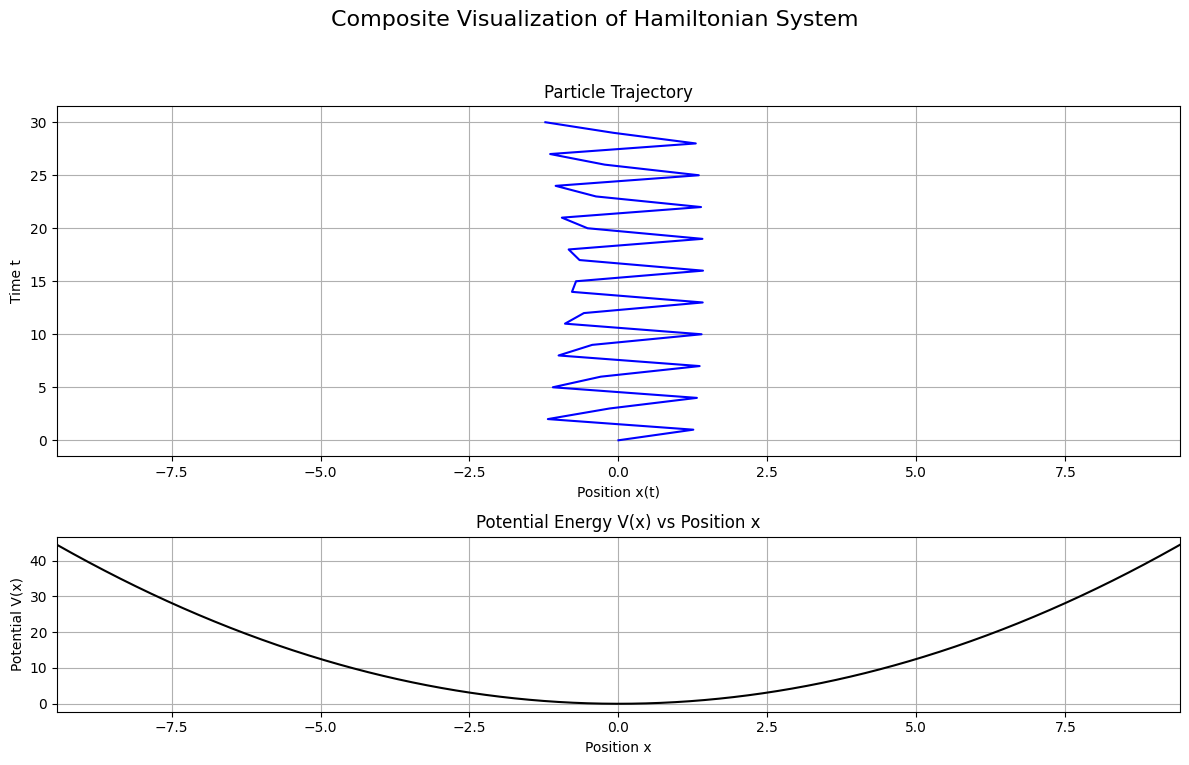

In [17]:
'''
H = p^2 / 2m + kx^2 / 2 + r^2 / 2m
G = r^2 / 2m + kx^2 / 4

x_dot = dH/dp * dG/dr - dH/dr * dG/dp
p_dot = dH/dr * dG/dx - dH/dx * dG/dr
r_dot = dH/dx * dG/dp - dH/dp * dG/dx
'''
# Input settings
k = 1.0  # Spring constant
m = 1.0  # Mass
t_max = 30.0  # Maximum time for simulation
delta_t = 0.0001  # Time step

# Define the Nambu dynamics equations
def x_dot(x, p, r):
    return p * r

def p_dot(x, p, r):
    return -(k / 2) * r * x

def r_dot(x, p, r):
    return -(k / 2) * p * x

# Initial conditions
x0 = 0.0
p0 = 3.0
r0 = 1.0

nambu_system = NambuSystem(x_dot, p_dot, r_dot, t_max, delta_t)

t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)

t_sampled, x_sampled, p_sampled, r_sampled = nambu_system.sample_data(t_array, x_array, p_array, r_array)

from plot_class import Plotter
energy_sampled = 0.5 * (p_sampled**2) / m + 0.5 * (r_sampled**2) / m + k * (x_sampled**2) / 2
potential = lambda x: k * (x**2) / 2

plotter = Plotter()
plotter.static_plots(t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.composite_plot(x_sampled, t_sampled, potential)

### Sampling different initial conditions

In [43]:
def sample_initial_conditions(N, x_bounds=(- 1, 1), psigma=1):
    """
    Sample N initial conditions (x0, p0) with probability proportional to exp(-H(x0, p0)),
    where H(x0, p0) = p0^2/(2m) + V(x0).

    Parameters:
        N (int): Number of samples to generate.
        x_bounds (tuple): Bounds for x0 sampling.
        psigma (float): Standard deviation for p0 sampling.

    Returns:
        List of tuples: [(x0_1, p0_1), (x0_2, p0_2), ..., (x0_N, p0_N)]
    """
    samples = []
    attempts = 0
    max_attempts = N * 1000  # To prevent infinite loop
    
    potential_min = min(potential(np.linspace(x_bounds[0], x_bounds[1], 1000)))
    print(f">>> Potential min: {potential_min}")

    while len(samples) < N and attempts < max_attempts:
        # Sample x0 uniformly within bounds
        x_proposal = np.random.uniform(x_bounds[0], x_bounds[1])
        # Compute acceptance probability for x0
        p_x = np.exp(-potential(x_proposal))
        p_x_max = np.exp(-potential_min)  # the minimum of potential corresponds to the maximum of p_x

        if np.random.uniform(0, p_x_max) < p_x:
            # Accept x0
            x0 = x_proposal
            # Sample p0 from Gaussian distribution
            p0 = np.random.normal(0, psigma)
            samples.append((x0, p0))
        attempts += 1
        
    if len(samples) < N:
        raise RuntimeError(f"Could not generate {N} samples within {max_attempts} attempts.")

    return samples

Potential min: 4.50901351802199e-06

>>> Generated 10000 sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))


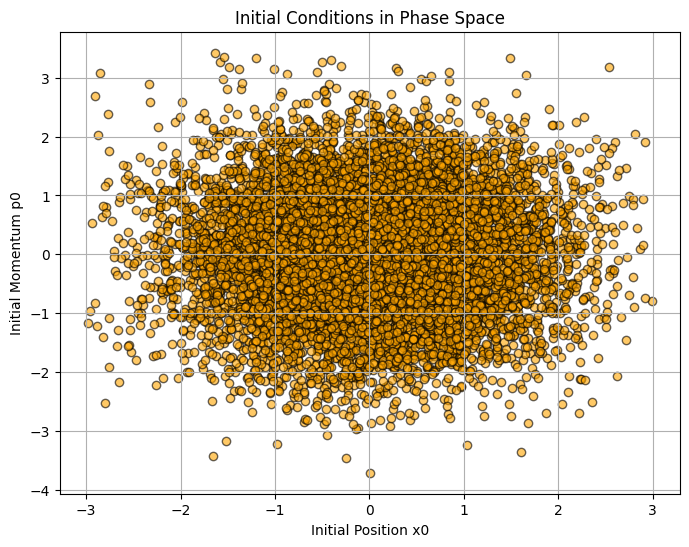

In [44]:
Nsamp = 10000
sampled_initial_conditions = sample_initial_conditions(N=Nsamp, x_bounds=(-3, 3), psigma=np.sqrt(m))

print(f"\n>>> Generated {Nsamp} sets of (x0, p0) satisfies p(x0, p0) ∝ exp(-H(x0, p0))")

# visualize the initial conditions in phase space
x0_samples, p0_samples = zip(*sampled_initial_conditions)
plt.figure(figsize=(8, 6))
plt.scatter(x0_samples, p0_samples, color='orange', alpha=0.6, edgecolor='k')
plt.title("Initial Conditions in Phase Space")
plt.xlabel("Initial Position x0")
plt.ylabel("Initial Momentum p0")
plt.grid(True)
plt.show()

### Calculate the average max displacement

In [45]:
print(">>> Using Hamiltonian Dynamics: ")
displacement_ls = []
for x0, p0 in tqdm(sampled_initial_conditions, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
    displacement_ls.append(np.max(x_array) - np.min(x_array))

average_displacement = np.mean(displacement_ls)
print(f"Average max displacement: {average_displacement:.2f}")

>>> Using Hamiltonian Dynamics: 


Loop in samples: 100%|██████████| 10000/10000 [00:23<00:00, 421.95it/s]

Average max displacement: 2.49


In [7]:
print(">>> Using Nambu Dynamics: ")
displacement_ls = []
for x0, p0 in tqdm(sampled_initial_conditions, desc="Loop in samples"):
    r0 = 1.0
    # r0 = np.random.normal(0, 1.0)
    t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)
    displacement_ls.append(np.max(x_array) - np.min(x_array))

average_displacement = np.mean(displacement_ls)
print(f"Average max displacement: {average_displacement:.2f}")

>>> Using Nambu Dynamics: 


Loop in samples: 100%|██████████| 100/100 [00:41<00:00,  2.44it/s]

Average max displacement: 3.99


### Test